In [59]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import os
import glob
from tqdm.notebook import tqdm

from astroddpm.utils.scheduler import InverseSquareRootScheduler, InversePowerLawScheduler, StepScheduler

In [60]:
DATA_FOLDER = '/mnt/home/dheurtel/ceph/01_data/'

DATA_DIR = 'CMB_PS_DIAG_H_ombh2'

In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [62]:
## Create a custom torch dataset that loads pairs of npy files (sample and theta) from a directory
class NpyDataset(Dataset):
    def __init__(self, root_dir, transform=None, split = 0.1, seed = 1337, train = True):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = glob.glob(os.path.join(self.root_dir, 'sample_*.npy'))
        self.thetas = glob.glob(os.path.join(self.root_dir, 'theta_*.npy'))
        self.samples.sort()
        self.thetas.sort()
        self.samples = self.samples[:630]
        self.thetas = self.thetas[:630]
        if train:
            np.random.seed(seed)
            np.random.shuffle(self.samples)
            np.random.seed(seed)
            np.random.shuffle(self.thetas)
            self.samples = self.samples[:int(len(self.samples)*(1-split))]
            self.thetas = self.thetas[:int(len(self.thetas)*(1-split))]
        else:
            np.random.seed(seed)
            np.random.shuffle(self.samples)
            np.random.seed(seed)
            np.random.shuffle(self.thetas)
            self.samples = self.samples[int(len(self.samples)*(1-split)):]
            self.thetas = self.thetas[int(len(self.thetas)*(1-split)):]
        self.length = len(self.samples)
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        sample = torch.from_numpy(np.load(self.samples[idx], allow_pickle=True).astype(np.float32))
        theta = torch.from_numpy(np.load(self.thetas[idx], allow_pickle=True).astype(np.float32))
        theta = (theta - torch.tensor([70, 32e-3]))/torch.tensor([20,25e-3])
        if self.transform:
            sample = self.transform(sample)
            theta = self.transform(theta)
        return sample, theta

def make_dataset(root_dir, transform=None, split = 0.1, seed = 1337):
    return NpyDataset(root_dir, transform, split, seed, True), NpyDataset(root_dir, transform, split, seed, False)

In [63]:
train_dataset, test_dataset = make_dataset(os.path.join(DATA_FOLDER, DATA_DIR))
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [64]:
## Create a simple MLP to emulate Sigma(theta)
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_hidden_layers=1):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_hidden_layers = n_hidden_layers

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_size))
        for i in range(n_hidden_layers):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
        self.layers.append(nn.Linear(hidden_size, output_size))

    def forward(self, x):
        for i in range(self.n_hidden_layers + 1):
            x = self.layers[i](x)
            x = F.relu(x)
        x = self.layers[-1](x)
        return x

In [65]:
emulator = MLP(2, 100, 128, 2).to(device)

In [ ]:
optimizer = torch.optim.AdamW(emulator.parameters(), lr=0.01, weight_decay=0.01)
scheduler = StepScheduler(optimizer, 50, 0.05, step_period=200)
loss_fn = torch.nn.MSELoss()


In [78]:
# Train the emulator
num_epochs = 1000
emulator.train()
progress_bar = tqdm(range(num_epochs))
running_mean_test_loss = 0.1
for epoch in range(num_epochs):
    train_loss = 0
    for _, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        output = emulator(batch[1].to(device))
        loss = loss_fn(output, batch[0].to(device))
        loss.backward()
        train_loss += loss.item()*len(batch[0])
        optimizer.step()
    train_loss /= len(train_dataset)
    test_loss = 0
    with torch.no_grad():
        for _, batch in enumerate(test_dataloader):
            output = emulator(batch[1].to(device))
            loss = loss_fn(output, batch[0].to(device))
            test_loss += loss.item()*len(batch[0])
    scheduler.step()
    test_loss /= len(test_dataset)
    running_mean_test_loss = 0.9*running_mean_test_loss + 0.1*test_loss
    progress_bar.set_description(f"Epoch {epoch+1} | Train loss: {train_loss:.6f}| Running mean test loss: {running_mean_test_loss:.6f}")
    progress_bar.update(1)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [96]:
def in_support(tensor):
    """Returns True if tensor is in support of the emulator."""
    return torch.logical_and(torch.logical_and(tensor[:,0] >= -1 ,tensor[:,0] <= 1) , torch.logical_and(tensor[:,1] >= -1 ,tensor[:,1] <= 1))

In [108]:
test_batch = next(iter(test_dataloader))

thetas_in_support = in_support(test_batch[1])

input = test_batch[1][thetas_in_support].to(device)
sigma_ps_hat = emulator(input)

In [109]:
train_batch = next(iter(train_dataloader))
input_train = train_batch[1].to(device)

sigma_train_hat = emulator(input_train)

In [110]:
loss = (sigma_ps_hat - test_batch[0][thetas_in_support].to(device)).square().mean(dim = 1)

In [113]:
loss.argmax()

tensor(13, device='cuda:0')

In [114]:
loss.max()

tensor(0.0007, device='cuda:0', grad_fn=<MaxBackward1>)

In [115]:
((np.exp(test_batch[0][13].cpu().detach())-np.exp(sigma_ps_hat[13].cpu().detach()))/np.exp(test_batch[0][13].cpu().detach()))

tensor([-0.0848,  0.0335,  0.1220,  0.1923,  0.2466,  0.2841,  0.3081,  0.3233,
         0.3330,  0.3408,  0.3490,  0.3583,  0.3697,  0.3833,  0.3990,  0.4161,
         0.4338,  0.4506,  0.4645,  0.4732,  0.4723,  0.4539,  0.4088,  0.3226,
         0.1750, -0.0539, -0.3670, -0.7204, -1.0218, -1.1878, -1.1943, -1.0818,
        -0.9112, -0.7303, -0.5602, -0.4108, -0.2865, -0.1903, -0.1234, -0.0845,
        -0.0742, -0.0940, -0.1375, -0.1913, -0.2390, -0.2671, -0.2665, -0.2324,
        -0.1728, -0.0972, -0.0148,  0.0702,  0.1518,  0.2267,  0.2921,  0.3476,
         0.3918,  0.4216,  0.4338,  0.4272,  0.3974,  0.3390,  0.2485,  0.1280,
        -0.0101, -0.1457, -0.2510, -0.2984, -0.2812, -0.2145, -0.1197, -0.0134,
         0.0911,  0.1839,  0.2603,  0.3202,  0.3635,  0.3876,  0.3919,  0.3782,
         0.3468,  0.2998,  0.2421,  0.1843,  0.1402,  0.1192,  0.1266,  0.1628,
         0.2218,  0.2909,  0.3615,  0.4289,  0.4894,  0.5405,  0.5806,  0.6102,
         0.6302,  0.6389,  0.6360,  0.62

/mnt/sw/nix/store/pvz51gzx2lyqpabf08xhd1y2kvw5rfdy-python-3.9.16-view/lib/python3.9/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 1.0, '[ 0.9213173  -0.93900126]')

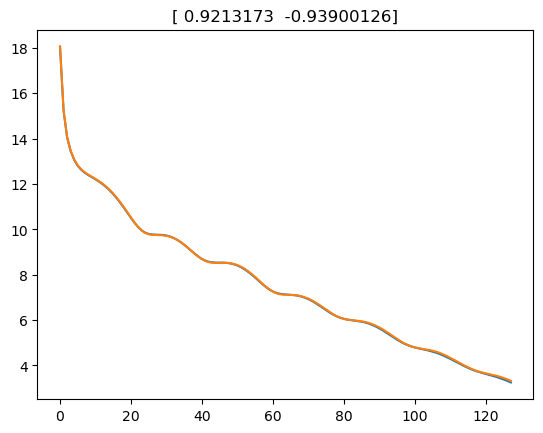

In [117]:
plt.plot(test_batch[0][thetas_in_support][13].cpu().detach())
plt.plot(sigma_ps_hat[13].cpu().detach())
plt.title(test_batch[1][thetas_in_support][13].cpu().detach().numpy())

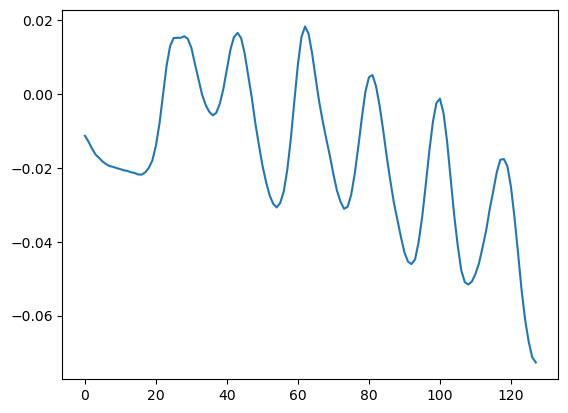

In [118]:
plt.plot(((np.exp(test_batch[0][thetas_in_support][13].cpu().detach())-np.exp(sigma_ps_hat[13].cpu().detach()))/np.exp(test_batch[0][thetas_in_support][13].cpu().detach())))

In [29]:
import time

In [30]:
for i in range(100):
    sigma_ps_hat = emulator(input)

begin = time.time()
for i in range(1000):
    sigma_ps_hat = emulator(input)
end = time.time()

print("Time per emulation: ", (end - begin) / 1000)


Time per emulation:  0.00020122075080871582


In [121]:
CKPT_FOLDER = '/mnt/home/dheurtel/ceph/02_checkpoints'

In [125]:
os.listdir(CKPT_FOLDER)

['DiscreteSBM_SigmaVPSDE_MHD_BPROJ_N_4000_bottleneck_32',
 'DiscreteSBM_SigmaVPSDE_MHD_BPROJ_N_4000_bottleneck_32_firstc_6',
 'DiscreteSBM_VPSDE_MHD_BPROJ_N_1000_bottleneck_32',
 'DiscreteSBM_VPSDE_MHD_BPROJ_N_4000_bottleneck_16',
 'DiscreteSBM_SigmaVPSDE_MHD_BPROJ_N_1000_bottleneck_32_firstc_4',
 'DiscreteSBM_SigmaVPSDE_MHD_BPROJ_N_1000_bottleneck_16_firstc_10',
 'DiscreteSBM_SigmaVPSDE_MHD_BPROJ_N_4000_bottleneck_16_firstc_4',
 'SIGMA_EMULATOR',
 'DiscreteSBM_SigmaVPSDE_MHD_BPROJ_N_4000_bottleneck_16_firstc_10',
 'DiscreteSBM_SigmaVPSDE_MHD_BPROJ_N_1000_bottleneck_8',
 'DiscreteSBM_SigmaVPSDE_MHD_BPROJ_N_8000_bottleneck_16',
 'DiscreteSBM_SigmaVPSDE_MHD_BPROJ_N_8000_bottleneck_32',
 'DiscreteSBM_VPSDE_MHD_BPROJ_N_8000_bottleneck_32',
 'DiscreteSBM_VPSDE_MHD_BPROJ_N_8000_bottleneck_16',
 'DiscreteSBM_SigmaVPSDE_MHD_BPROJ_N_1000_bottleneck_16_firstc_4',
 'DiscreteSBM_VPSDE_MHD_BPROJ_N_4000_bottleneck_8',
 'DPPM_exp0',
 'DiscreteSBM_VPSDE_MHD_BPROJ_N_1000_bottleneck_16',
 'DiscreteSBM_S

In [124]:
os.mkdir(os.path.join(CKPT_FOLDER, 'SIGMA_EMULATOR'))

In [126]:
MODEL_ID = 'Emulator_H0_ombh2_1'

In [127]:
ckpt = {'network': emulator.state_dict(), 'optimizer': optimizer.state_dict(), 'scheduler' : scheduler.state_dict()}

In [128]:
torch.save(ckpt, os.path.join(CKPT_FOLDER, 'SIGMA_EMULATOR', MODEL_ID + '.pt'))